# *Deliverable 2*: Preprocessing

* Import dataset and necessary libraries
<br><br>  
* Handling missing values
  * Drop missing mpg feature values
  * Scaling data
  * Fill hp missing values creating a custom function
  <br><br>  
* Handling outliers
  * Detect Multivariate outliers using Isolation Forest
  * Visualise outliers with 2D PCA
  * Drop outliers 
 <br><br>
* Encoding categorical features
<br><br>   



## Import dataset and libraries

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import plotly.express as px
import os
nb_path = os.path.abspath('')
file_path = os.path.join(nb_path, '../../data/df_eda.csv')
df = pd.read_csv(file_path)

In [22]:
df

,mpg,cylinders,displayments,horsepower,weight,acceleration,model year,origin,car name,outlier,car brand,model
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,Normal,chevrolet,chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,Normal,buick,skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,Normal,plymouth,satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,Normal,amc,rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,Normal,ford,torino
...,...,...,...,...,...,...,...,...,...,...,...,...
401,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl,Normal,ford,mustang gl
402,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup,Outlier,volkswagen,pickup
403,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage,Normal,dodge,rampage
404,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger,Normal,ford,ranger


## Handling missing values & scaling the data 

In [23]:
missing_values = df.isnull().sum()
missing_values

mpg             8
cylinders       0
displayments    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
outlier         0
car brand       0
model           2
dtype: int64

Missing values for mpg, horsepower and model.
Since mpg is the target column, it is better not to be filled with a predicted value.
Missing model value is not a concern in regards to our analysis. 
Horsepower will be filled using a custom function for a more educated guess on predicted value

### Dropping mpg N/As

In [24]:
# Drop rows where 'mpg' is missing
df = df.dropna(subset=['mpg'])

### Custom function for filling hp N/As <br>


For each car with a missing hp value find a similar car and use its hp value. To find the similar car, first scale the data, then for every missing hp car, substract its feature values from all other cars' respective feature values. keep the absolute value of the substraction (distance) and for each car create a score by suming all feature distances. The car with the lowest score is the most similar car to the one in question. Fill the missing hp value with the one of the most similar car  

In [25]:
# Scale features 
scaler = StandardScaler()
features_to_scale = ['mpg','cylinders', 'displayments', 'horsepower','weight', 'acceleration']
df_scaled = df.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])
df_scaled.head()
df_scaled.loc[[38, 75]]

,mpg,cylinders,displayments,horsepower,weight,acceleration,model year,origin,car name,outlier,car brand,model
38,0.190289,-0.856321,-0.916334,NaN,-1.092988,1.246054,71,1,ford pinto,Normal,ford,pinto
75,-1.346959,1.498191,1.503514,1.314463,1.810850,-0.750880,72,1,buick lesabre custom,Normal,buick,lesabre custom


In [26]:
# Define the function to find the most similar car and impute missing values
def similar_car(target_col, features):
    """
    Impute missing values in the target column by finding the most similar car.
    
    Parameters:
        target_col (str): The name of the column to predict 
        features (list): List of features to use for similarity comparison.
    """
    imputed_values = []  # To store the imputed values and their sources
    
    for idx, row in df_scaled[df_scaled[target_col].isnull()].iterrows():
        # Exclude the row with missing value
        others = df_scaled[df_scaled[target_col].notnull()]
        
        # Compute absolute differences and sum them row-wise 
        differences = others[features].sub(row[features], axis=1).abs().sum(axis=1)
        
        # Find the index of the most similar car (minimum difference)
        most_similar_idx = differences.idxmin()
        
        # Assign the target column value from the most similar car
        imputed_value = df_scaled.loc[most_similar_idx, target_col]
        df_scaled.loc[idx, target_col] = imputed_value
        
        # Store the imputed value and corresponding similar car
        imputed_values.append((idx, imputed_value, most_similar_idx))
    
    # Display the imputed values
    print("Imputed Values for Missing Entries in '{}':".format(target_col))
    for idx, value, similar_idx in imputed_values:
        print(f"Row {idx}: Imputed Value = {value} (Based on Similar Car at Row {similar_idx})")

# Perform similar car imputation for 'horsepower' 
features = ['mpg','cylinders', 'displayments', 'weight', 'acceleration']
similar_car(target_col='horsepower', features=features)

# Check the updated 'horsepower' column
df_scaled[['horsepower']]
df_scaled.head()

Imputed Values for Missing Entries in 'horsepower':
Row 38: Imputed Value = -1.1567907473949541 (Based on Similar Car at Row 62)
Row 133: Imputed Value = -0.42842135527660774 (Based on Similar Car at Row 373)
Row 337: Imputed Value = -1.2088171325462647 (Based on Similar Car at Row 350)
Row 343: Imputed Value = -0.16828942952005543 (Based on Similar Car at Row 186)
Row 361: Imputed Value = -0.68855328103316 (Based on Similar Car at Row 324)
Row 382: Imputed Value = -0.37639497012529727 (Based on Similar Car at Row 322)


,mpg,cylinders,displayments,horsepower,weight,acceleration,model year,origin,car name,outlier,car brand,model
0,-0.706439,1.498191,1.090604,0.664133,0.630870,-1.295498,70,1,chevrolet chevelle malibu,Normal,chevrolet,chevelle malibu
1,-1.090751,1.498191,1.503514,1.574594,0.854333,-1.477038,70,1,buick skylark 320,Normal,buick,skylark 320
2,-0.706439,1.498191,1.196232,1.184397,0.550470,-1.658577,70,1,plymouth satellite,Normal,plymouth,satellite
3,-0.962647,1.498191,1.061796,1.184397,0.546923,-1.295498,70,1,amc rebel sst,Normal,amc,rebel sst
4,-0.834543,1.498191,1.042591,0.924265,0.565841,-1.840117,70,1,ford torino,Normal,ford,torino


In [27]:
df_scaled.isnull().sum()

mpg             0
cylinders       0
displayments    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
outlier         0
car brand       0
model           2
dtype: int64

## Handling outliers
As noticed in the 1st Deliverable there are some outliers considering the range of each feature, although we should consider multivariate outliers

### Isolation Forest: Multivariate outlier detection(based on the combination of all other features)

A value might not be an outlier in its own column but could be an outlier in combination with other features. <br>




In [28]:
# Define columns to use for outlier detection
columns = ['mpg', 'displayments', 'weight', 'cylinders', 'horsepower', 'acceleration']

# Fit Isolation Forest
iso_forest = IsolationForest(n_estimators=600, contamination=0.05
                             , random_state=42)
df_scaled["anomaly_score"] = iso_forest.fit_predict(df_scaled[columns])

# Mark outliers
df_scaled["multivariate_outlier"] = df_scaled["anomaly_score"].map({1: "Normal", -1: "multivariate_outlier"})

# Count outliers
outlier_count = df_scaled["multivariate_outlier"].value_counts()
print("multivariate outlier count:\n", outlier_count)

# Interactive 3D Scatter Plot (Coloring Outliers in Green)
fig = px.scatter_3d(
    df_scaled,
    x="weight",
    y="displayments",
    z="mpg",
    color="multivariate_outlier",  # Highlighting outliers
    color_discrete_map={"Multivariate_outlier": "green", "Normal": "blue"},
    title="Isolation Forest Outlier Detection for Selected Features",
    labels={"weight": "Weight", "displayments": "Displacement", "mpg": "Miles Per Gallon"}
)
# Adjust the size of the plot
fig.update_layout(
    width=1000,  # Set the width in pixels
    height=800   # Set the height in pixels
)
fig.show()

multivariate outlier count:
 multivariate_outlier
Normal                  378
multivariate_outlier     20
Name: count, dtype: int64


### Visualise mutlivariate outliers by projecting dataset in a 2dimensional space using PCA

<Axes: >

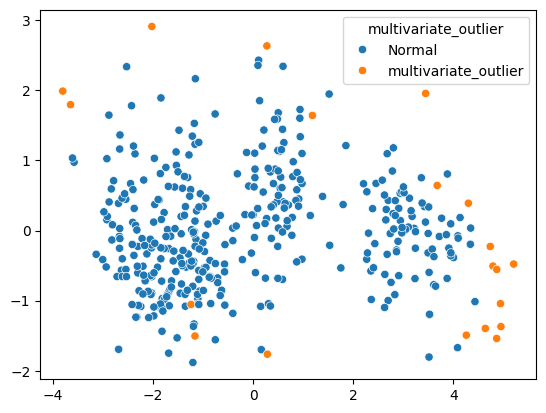

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled[columns])
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df_scaled['multivariate_outlier'])

In [30]:
df_scaled

,mpg,cylinders,displayments,horsepower,weight,acceleration,model year,origin,car name,outlier,car brand,model,anomaly_score,multivariate_outlier
0,-0.706439,1.498191,1.090604,0.664133,0.630870,-1.295498,70,1,chevrolet chevelle malibu,Normal,chevrolet,chevelle malibu,1,Normal
1,-1.090751,1.498191,1.503514,1.574594,0.854333,-1.477038,70,1,buick skylark 320,Normal,buick,skylark 320,1,Normal
2,-0.706439,1.498191,1.196232,1.184397,0.550470,-1.658577,70,1,plymouth satellite,Normal,plymouth,satellite,1,Normal
3,-0.962647,1.498191,1.061796,1.184397,0.546923,-1.295498,70,1,amc rebel sst,Normal,amc,rebel sst,1,Normal
4,-0.834543,1.498191,1.042591,0.924265,0.565841,-1.840117,70,1,ford torino,Normal,ford,torino,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0.446497,-0.856321,-0.513026,-0.480448,-0.213324,0.011586,82,1,ford mustang gl,Normal,ford,mustang gl,1,Normal
402,2.624265,-0.856321,-0.925936,-1.364896,-0.993671,3.279296,82,2,vw pickup,Outlier,volkswagen,pickup,-1,multivariate_outlier
403,1.087017,-0.856321,-0.561039,-0.532474,-0.798585,-1.440730,82,1,dodge rampage,Normal,dodge,rampage,1,Normal
404,0.574601,-0.856321,-0.705077,-0.662540,-0.408411,1.100822,82,1,ford ranger,Normal,ford,ranger,1,Normal


In [31]:
# Get indices of multivariate outliers and compare them to feature outliers
multivariate_outliers = df_scaled[df_scaled['anomaly_score'] == -1].index.tolist()
outliers=df_scaled[df_scaled['outlier'] == "Outlier"].index.tolist()
all_outliers = list(set(multivariate_outliers + outliers))

# Print the number of outliers found
print(f"Total Multivariate Outliers: {len(multivariate_outliers)}")
print(f"Total Feature Outliers: {len(outliers)}")
print(f"Total Unique Outliers to Remove: {len(all_outliers)}")

# Print or use the list of outlier indices if needed
print("Indices of multivariate outliers:", multivariate_outliers)
print ("Indices of outliers:", outliers)

Total Multivariate Outliers: 20
Total Feature Outliers: 14
Total Unique Outliers to Remove: 23
Indices of multivariate outliers: [6, 7, 8, 19, 31, 32, 34, 74, 97, 101, 102, 118, 123, 306, 307, 333, 340, 341, 372, 402]
Indices of outliers: [6, 7, 8, 16, 19, 31, 66, 101, 102, 123, 306, 329, 333, 402]


### Drop multivariate & feature outliers

In [32]:
# Drop the combined outliers from the dataset
df_scaled_cleaned = df_scaled.drop(index=all_outliers).reset_index(drop=True)

# Print new dataset shape
print(f"Original Dataset Shape: {df_scaled.shape}")
print(f"Cleaned Dataset Shape: {df_scaled_cleaned.shape}")

Original Dataset Shape: (398, 14)
Cleaned Dataset Shape: (375, 14)


## Encoding categorical features

In [33]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# label encoding to the 'car brand' column
df_scaled_cleaned['car_name_encoded'] = label_encoder.fit_transform(df_scaled_cleaned['car brand'])

print(df_scaled_cleaned[['car brand', 'car_name_encoded']])

     car brand  car_name_encoded
0    chevrolet                 5
1        buick                 3
2     plymouth                19
3          amc                 0
4         ford                10
..         ...               ...
370  chevrolet                 5
371       ford                10
372      dodge                 8
373       ford                10
374  chevrolet                 5

[375 rows x 2 columns]


In [34]:
# Display the mapping of numbers to car brands
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Encoding Mapping:")
for brand, number in mapping.items():
    print(f"{number}: {brand}")

Label Encoding Mapping:
0: amc
1: audi
2: bmw
3: buick
4: cadillac
5: chevrolet
6: chrysler
7: datsun
8: dodge
9: fiat
10: ford
11: honda
12: mazda
13: mercedes
14: mercury
15: nissan
16: oldsmobile
17: opel
18: peugeot
19: plymouth
20: pontiac
21: renault
22: saab
23: subaru
24: toyota
25: triumph
26: volkswagen
27: volvo


Note: we now have 28 car brands instead of 30 since one was dropped as an outlier (hi) and an other as a missing mpg value(citroen)

In [35]:
#cleand but not scaled dataset
# Define the features that were scaled
features_to_unscale = ['mpg', 'cylinders', 'displayments','horsepower' 'weight', 'acceleration', 'model year']

# Inverse transform to restore original values
df_cleaned = df_scaled_cleaned.copy()
df_cleaned[features_to_scale] = scaler.inverse_transform(df_scaled_cleaned[features_to_scale])

In [36]:
df_cleaned

,mpg,cylinders,displayments,horsepower,weight,acceleration,model year,origin,car name,outlier,car brand,model,anomaly_score,multivariate_outlier,car_name_encoded
0,18.0,8.0,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,Normal,chevrolet,chevelle malibu,1,Normal,5
1,15.0,8.0,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,Normal,buick,skylark 320,1,Normal,3
2,18.0,8.0,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,Normal,plymouth,satellite,1,Normal,19
3,16.0,8.0,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,Normal,amc,rebel sst,1,Normal,0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70,1,ford torino,Normal,ford,torino,1,Normal,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,27.0,4.0,151.0,90.0,2950.0,17.3,82,1,chevrolet camaro,Normal,chevrolet,camaro,1,Normal,5
371,27.0,4.0,140.0,86.0,2790.0,15.6,82,1,ford mustang gl,Normal,ford,mustang gl,1,Normal,10
372,32.0,4.0,135.0,84.0,2295.0,11.6,82,1,dodge rampage,Normal,dodge,rampage,1,Normal,8
373,28.0,4.0,120.0,79.0,2625.0,18.6,82,1,ford ranger,Normal,ford,ranger,1,Normal,10


In [37]:
#sorting by mpg values
df_cleaned= df_cleaned.sort_values(by='mpg')
 
#calculating 33.3rd and 66.6th percentiles
q1 = df_cleaned['mpg'].quantile(0.333)
q2 = df_cleaned['mpg'].quantile(0.666)
df_cleaned['mpg_classes'] = pd.qcut(df_cleaned['mpg'], q=[0, 0.333, 0.666, 1], labels=[0, 1, 2])
 
#distribution
distribution = df_cleaned['mpg_classes'].value_counts()
 
#results
print("Quantile thresholds:")
print(f"q1: {q1}")
print(f"q2: {q2}")
print("\nLabel distribution:")
print(distribution)

Quantile thresholds:
q1: 19.0
q2: 27.0

Label distribution:
mpg_classes
0    129
1    127
2    119
Name: count, dtype: int64


In [38]:
# Save the reverted dataset
df_cleaned.to_csv(os.path.join(nb_path, '../../data/df_cleaned.csv'))

In [39]:
!jupyter nbconvert --to script D2.ipynb

[NbConvertApp] Converting notebook D2.ipynb to script
[NbConvertApp] Writing 8850 bytes to D2.py
